# SUV Purchase Predictor

In this notebook, we will train a logistic regression model to predict whether or not one should buy an SUV given their age, gender, and annual salary. The purpose of this programming exercise is to expose students to the **PyTorch** framework, as well as diving deeper into the architecture of learning algorithms.

## Introduction

Suppose you are thinking about buying an SUV, however you are not sure whether or not you should drop the money on a new car. You decide to make a classifier that learns people's decisions in the past to aid you in your own decision. You are given a dataset with the features `UserID`, `Gender`, `Age`, `EstimatedSalary`, as well as your label `Purchased`.

## Unpacking the dataset

In [1]:
!unzip colab
!pip install numpy pandas torch=1.8.1 sklearn matplotlib seaborn


import numpy as np
import pandas as pd
import torch

pd.set_option("display.max_columns", None)

Archive:  colab.zip
   creating: datasets/
  inflating: datasets/pokemon.csv    
  inflating: datasets/SUV_Purchase.csv  
   creating: images/
  inflating: images/umaru.png        
  inflating: disp_utils.py           
  inflating: requirements.txt        


In [2]:
data = pd.read_csv('datasets/SUV_Purchase.csv')
data

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [3]:
# Converting Gender into categorical values
gender_dummies = pd.get_dummies(data['Gender'])
gender_dummies

,Female,Male
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
395,1,0
396,0,1
397,1,0
398,0,1


In [4]:
# let 0 = male, 1 = female
data['gender_num'] = gender_dummies['Female']
data

,User ID,Gender,Age,EstimatedSalary,Purchased,gender_num
0,15624510,Male,19,19000,0,0
1,15810944,Male,35,20000,0,0
2,15668575,Female,26,43000,0,1
3,15603246,Female,27,57000,0,1
4,15804002,Male,19,76000,0,0
...,...,...,...,...,...,...
395,15691863,Female,46,41000,1,1
396,15706071,Male,51,23000,1,0
397,15654296,Female,50,20000,1,1
398,15755018,Male,36,33000,0,0


In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

# Data selection
features = data[['Age', 'EstimatedSalary', 'gender_num']].to_numpy()
labels = data[['Purchased']].to_numpy()

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.2)
poly= PolynomialFeatures(degree=3)

# Create Polynomial Features
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

# Display shapes
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

# Convert into pytorch tensors 
X_train_t = torch.from_numpy(X_train).float()
Y_train_t = torch.from_numpy(Y_train).float()

(320, 20)
(320, 1)
(80, 20)
(80, 1)


In [6]:
# Number of positive and negative (females and males)
positives = np.sum(data['Purchased'].to_numpy())
negatives = int(len(data.index) - positives)

print(f'Num of positives: {positives}')
print(f'Num of negatives: {negatives}\n')

# Calculate Class Weights to balance classes
pos_weight = len(data.index)/(2 * positives)
neg_weight = len(data.index)/(2 * negatives)

print(f"positive weight: {pos_weight}")
print(f"negative weight: {neg_weight}")


def class_weights(Y_train, pos_weight, neg_weight):
    """
    calculates the weights for each and every training example
    Args:
        Y_train: training labels
        pos_weight: Weight of positive labels
        neg_weight: Weight of negative labels
    Returns:
        weights: an np.array where its shape is identical to Y_train
    """
    
    pos_mask = Y_train.astype(bool)
    neg_mask = ~Y_train.astype(bool)

    pos_mask = pos_mask.astype(np.float32) * pos_weight

    neg_mask = neg_mask.astype(np.float32) * neg_weight
    return pos_mask + neg_mask
    

weights = class_weights(Y_train, pos_weight, neg_weight)
print(weights.shape)

Num of positives: 143
Num of negatives: 257

positive weight: 1.3986013986013985
negative weight: 0.7782101167315175
(320, 1)


## Training the Logistic Regression Model

Recall from the Topic 2 Notebook, Logistic Regression differs from Linear Regression in terms of the Activation function (sigmoid) and the Cost function (BCE). Most other aspects are similar. Here we will use the `BatchNorm1d` layer to normalize the inputs.

In [12]:
from torch.nn import Module, Linear, BCELoss, BatchNorm1d
from torch.optim import SGD

class Logreg(Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear  = Linear(input_dim, output_dim)
        self.bn = BatchNorm1d(input_dim)
        
    def forward(self, x):
        # Batch norm is used solely to normalize the inputs
        x = self.bn(x)
        z = self.linear(x)
        y_pred = torch.sigmoid(z)
        return y_pred
    
    def fit(self, X_train, Y_train, epochs, loss_func, opt):
        """
        Trains the model.
        Args:
            X_train, Y_train: training set and labels. Must be 
                            torch.tensor
            epochs: The number of passes over your training dataset
            loss_func: optimizing criterion
            opt: optimizing algorithm
        """
        for i in range(epochs):
            self.train()
            opt.zero_grad()
        
            Y_pred = self(X_train)
            loss = loss_func(Y_pred, Y_train)
            
            print(f"iteration {i+1}: loss: {loss.item()}")
        
            loss.backward()
            opt.step()

            del Y_pred
            del loss

In [19]:
LEARNING_RATE = 0.02
EPOCHS = 50000

# Initializing a model
model = Logreg(X_train.shape[1], 1).cpu()

# Optimizing criterion and optimizing algorithm
# ignore talking about momentum and nesterov
criterion = BCELoss(weight=torch.from_numpy(weights).float())
optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, nesterov=True)


model.fit(X_train_t, Y_train_t, EPOCHS, criterion, optimizer)

Streaming output truncated to the last 5000 lines.
iteration 45001: loss: 0.22629141807556152
iteration 45002: loss: 0.22629137337207794
iteration 45003: loss: 0.22629134356975555
iteration 45004: loss: 0.22629132866859436
iteration 45005: loss: 0.22629129886627197
iteration 45006: loss: 0.22629129886627197
iteration 45007: loss: 0.22629126906394958
iteration 45008: loss: 0.226291224360466
iteration 45009: loss: 0.226291224360466
iteration 45010: loss: 0.226291224360466
iteration 45011: loss: 0.2262912094593048
iteration 45012: loss: 0.22629117965698242
iteration 45013: loss: 0.22629117965698242
iteration 45014: loss: 0.22629114985466003
iteration 45015: loss: 0.22629110515117645
iteration 45016: loss: 0.22629110515117645
iteration 45017: loss: 0.22629103064537048
iteration 45018: loss: 0.22629103064537048
iteration 45019: loss: 0.2262910157442093
iteration 45020: loss: 0.2262910157442093
iteration 45021: loss: 0.2262909859418869
iteration 45022: loss: 0.2262909859418869
iteration 4502

In [20]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sn # used for creating a heatmap for displaying confusion matrix

# testing data torch.tensors
X_test_t = torch.from_numpy(X_test).float()
Y_test_t = torch.from_numpy(Y_test).float()

# Eval mode -- Explain that it is used to 
# set the model into evaluation mode, which 
# turns off certain layers used during training
model.eval()

# prediction
Y_pred_t = model(X_test_t)
# convert probabilities to 0 or 1
Y_pred = (Y_pred_t.detach().numpy() > 0.5).astype(np.int32)

F1 = f1_score(Y_test, Y_pred)
accuracy = np.sum(Y_pred == Y_test)/Y_test.size

print(f"F1 Score: {F1}")
print(f"Accuracy: {accuracy}")

F1 Score: 0.8852459016393444
Accuracy: 0.9125


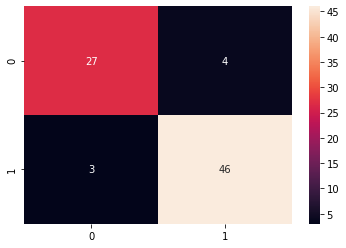

In [21]:
def plot_conf_mat(Y_pred, Y_gt):
    """
    Plots Confusion Matrix
    Args:
        Y_pred: predictions array (np.array)
        Y_gt: ground truth array (np.array)
    """
    conf_mat = pd.DataFrame(confusion_matrix(Y_gt, Y_pred, labels=[1,0]))
    sn.heatmap(conf_mat, annot=True)
    
plot_conf_mat(Y_pred, Y_test)

### Observations

After training our Logistic Regression Classifier, we observe a very high Accuracy and F1 Score, which is awesome! Lets keep track of our progress:

| Model | Observations | Accuracy | F1 | 
|:- |:- |:- | :- |
| Logistic Regression | High accuracy, very few false positives and false negatives | 88% | 88% |

In [27]:
trace = torch.jit.trace(model, torch.rand((1, 20)))
trace.save('suv_predictor.pt')
torch.save(model.state_dict(), 'suv_predictor_weights.pt') 